In [1]:
#Загружаем библиотеки

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, LSTM 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
base_data16 = pd.read_csv('/content/drive/My Drive/datasets/date_csv/16_17.csv', sep=';')
base_data18 = pd.read_csv('/content/drive/My Drive/datasets/date_csv/18_19.csv', sep=';')
data16_17 = base_data16.iloc[:,2:]
data18_19 = base_data18.iloc[:,2:]


In [4]:
# Объединяем базы из двух файлов
data = data16_17.copy()                 
data = pd.concat([data16_17,data18_19])
data = np.array(data)  

print(len(data16_17))
print(len(data18_19))
print(len(data))

263925
217947
481872


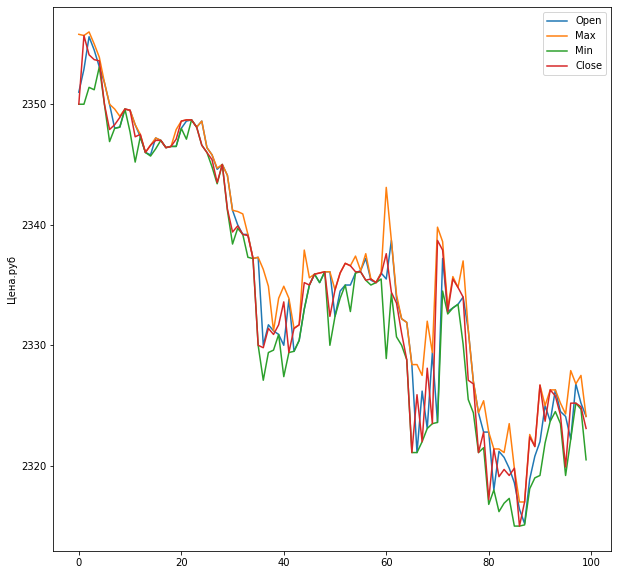

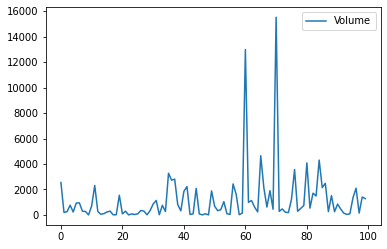

In [5]:
#Отображаем исходные от точки start и длинной step
start = 0            
step = 100 

#Заполняем текстовые названия каналов данных
chanelNames = ['Open', 'Max', 'Min', 'Close', 'Volume']

plt.figure(figsize=(10, 10))
for i in range(4):
  plt.plot(data[start:start+step,i], 
          label=chanelNames[i])
plt.ylabel('Цена.руб')
plt.legend()
plt.show()

plt.plot(data[start:start+step,4], label="Volume")
plt.legend()
plt.show()

In [6]:
#Формируем параметры загрузки данных
xLen = 300                       
valLen = 30000                   
stepsForward = 10
trainLen = data.shape[0]-valLen

#Делим данные на тренировочную и тестовую выборки 
xTrain,xTest = data[:trainLen-stepsForward], data[trainLen+xLen+2:-stepsForward+1]

#Масштабируем данные (отдельно для X и Y), чтобы их легче было скормить сетке
xScaler = StandardScaler()
xScaler.fit(xTrain)
xTrain = xScaler.transform(xTrain)
xTest = xScaler.transform(xTest)

#Для подготовки yTrain на 10 шагов вперед необходимо создать дополнительный датасет
yTrain = np.array([data[:trainLen,3][i:i+stepsForward] for i in range(trainLen-stepsForward)])
yTest = np.array([data[trainLen+xLen+2:,3][i:i+stepsForward] for i in range(valLen-xLen-stepsForward-1)])
yScaler = StandardScaler()
yScaler.fit(yTrain)
yTrain = yScaler.transform(yTrain)
yTest = yScaler.transform(yTest)

#Создаем генератор для обучения
trainDataGen = TimeseriesGenerator(xTrain, yTrain, length=xLen, sampling_rate=1, batch_size=20)                
         
#Создаем аналогичный генератор для валидации при обучении
testDataGen = TimeseriesGenerator(xTest, yTest, length=xLen, sampling_rate=1, batch_size=20)
                                              

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
22579/22579 [==============================] - 50s 2ms/step - loss: 0.0457 - val_loss: 0.0085
Epoch 2/20
22579/22579 [==============================] - 50s 2ms/step - loss: 0.0058 - val_loss: 9.2791e-04
Epoch 3/20
22579/22579 [==============================] - 50s 2ms/step - loss: 5.1198e-04 - val_loss: 0.0019
Epoch 4/20
22579/22579 [==============================] - 50s 2ms/step - loss: 3.9768e-04 - val_loss: 3.2405e-04
Epoch 5/20
22579/22579 [==============================] - 52s 2ms/step - loss: 3.1654e-04 - val_loss: 2.6821e-04
Epoch 6/20
22579/22579 [==============================] - 50s 2ms/step - loss: 3.7641e-04 - val_loss: 1.7360e-04
Epoch 7/20
22579/22579 [==============================] - 51s 2ms/step - loss: 2.6627e-04 - val_loss: 2.0510e-04
Epoch 8/20
22579/22579 [==============================] - 50s 2ms/step - loss: 3.2412e-04 - val_loss: 1.3381e-04
Epoch 9/20
22579/22579 [============

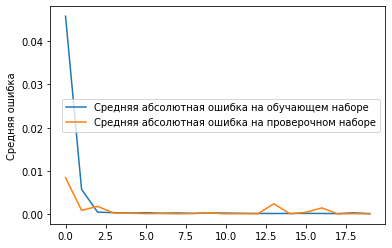

In [7]:
#Создаём нейронку
modelD = Sequential()
modelD.add(Dense(150,input_shape = (xLen,5), activation="linear" )) # 5 - количество каналов
modelD.add(Flatten())
modelD.add(Dense(yTrain.shape[1], activation="linear"))

#Компилируем
modelD.compile(loss="mse", optimizer=Adam(lr=1e-4))

#Запускаем обучение
history = modelD.fit_generator(
                    trainDataGen, 
                    epochs=20, 
                    verbose=1, 
                    validation_data = testDataGen 
                    )

#Выводим графики
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [8]:
# Функция рассчитываем результаты прогнозирования сети
def getPred(currModel, xVal, yVal, yScaler):
  predVal = yScaler.inverse_transform(currModel.predict(xVal))
  yValUnscaled = yScaler.inverse_transform(yVal)
  return (predVal, yValUnscaled)

# Функция визуализирует графики, что предсказала сеть и какие были правильные ответы
def showPredict(start, step, channel, predVal, yValUnscaled):
  plt.plot(predVal[start:start+step, 0],
           label='Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel], 
           label='Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Значение Close')
  plt.legend()
  plt.show()
  
# Функция расёта корреляции дух одномерных векторов
def correlate(a, b):
  # Рассчитываем основные показатели
  ma = a.mean()
  mb = b.mean() 
  mab = (a*b).mean() 
  sa = a.std() 
  sb = b.std() 
  val = 1
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val

# Функция рисуем корреляцию прогнозированного сигнала с правильным
def showCorr(channels, corrSteps, predVal, yValUnscaled):
  for ch in channels:
    corr = [] 
    yLen = yValUnscaled.shape[0]
    for i in range(corrSteps):
      corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:, 0]))

    own_corr = []
    for i in range(corrSteps):
      own_corr.append(correlate(yValUnscaled[:yLen-i,ch], yValUnscaled[i:, ch]))
    plt.plot(corr, label='Предсказание на ' + str(ch+1) + ' шаг')
    plt.plot(own_corr, label='Эталон')

  plt.xlabel('Время')
  plt.ylabel('Значение')
  plt.legend()
  plt.show()

In [9]:
#Создадим генератор проверочной выборки, из которой потом вытащим xVal, yVal для проверки
DataGen = TimeseriesGenerator(xTest, yTest, length=xLen, sampling_rate=1, batch_size=len(xTest))
xVal = []
yVal = []
for i in DataGen:
  xVal.append(i[0])
  yVal.append(i[1])

xVal = np.array(xVal)
yVal = np.array(yVal)


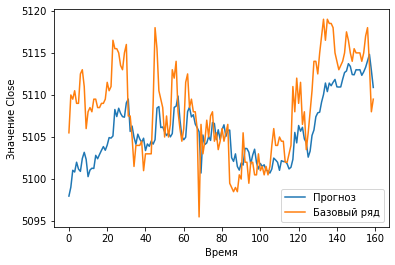

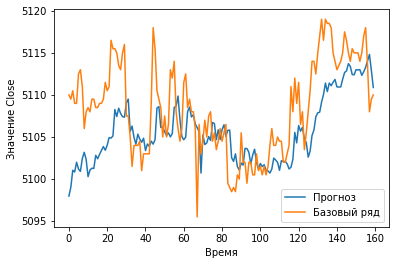

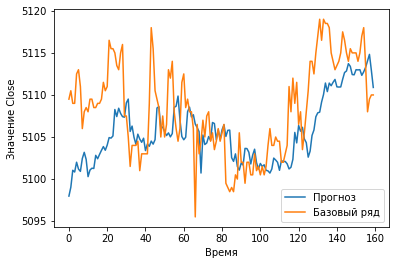

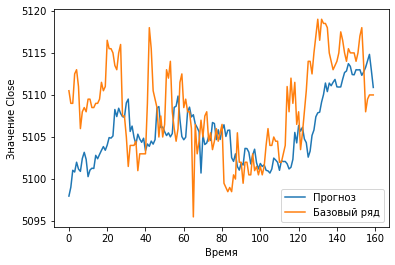

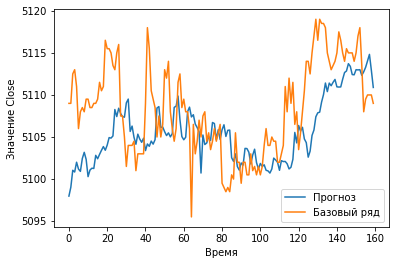

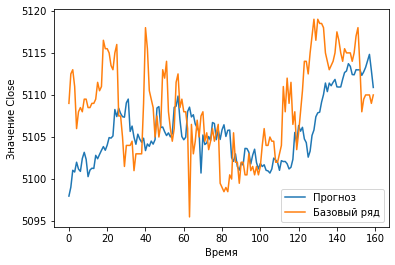

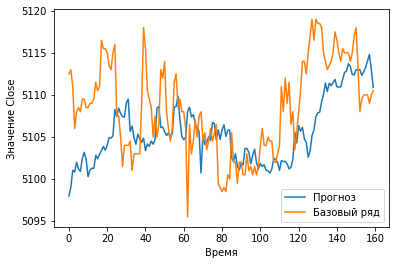

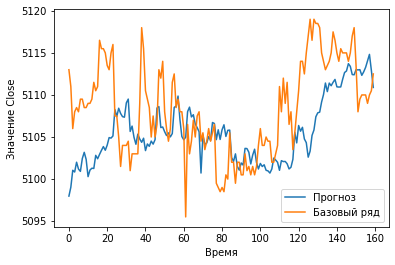

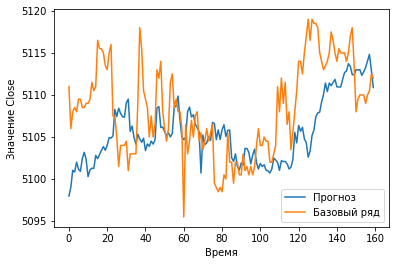

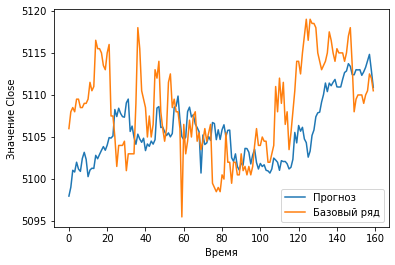

In [10]:
#Прогнозируем данные текущей сетью
currModel = modelD 
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler) 
for i in range(10):
    showPredict(0, 160, i, predVal, yValUnscaled)

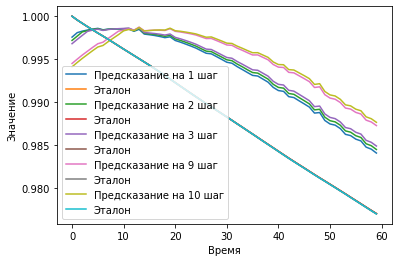

In [11]:
showCorr([0, 1, 2, 8, 9], 60, predVal, yValUnscaled)

Epoch 1/20
22579/22579 [==============================] - 56s 2ms/step - loss: 0.1402 - val_loss: 7.2625e-04
Epoch 2/20
22579/22579 [==============================] - 54s 2ms/step - loss: 0.0035 - val_loss: 5.6052e-04
Epoch 3/20
22579/22579 [==============================] - 54s 2ms/step - loss: 0.0023 - val_loss: 4.1974e-04
Epoch 4/20
22579/22579 [==============================] - 54s 2ms/step - loss: 0.0018 - val_loss: 5.1489e-04
Epoch 5/20
22579/22579 [==============================] - 54s 2ms/step - loss: 8.2364e-04 - val_loss: 2.5836e-04
Epoch 6/20
22579/22579 [==============================] - 54s 2ms/step - loss: 0.0010 - val_loss: 3.4402e-04
Epoch 7/20
22579/22579 [==============================] - 56s 2ms/step - loss: 9.0835e-04 - val_loss: 7.1434e-04
Epoch 8/20
22579/22579 [==============================] - 54s 2ms/step - loss: 5.5870e-04 - val_loss: 2.4679e-04
Epoch 9/20
22579/22579 [==============================] - 54s 2ms/step - loss: 4.9848e-04 - val_loss: 6.1596e-04
Epo

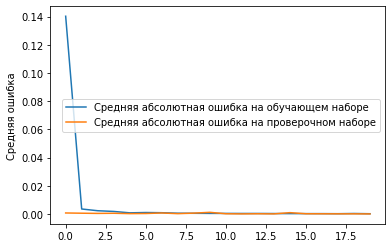

In [12]:
modelC = Sequential()

modelC.add(Conv1D(200, 5, input_shape = (xLen,5), activation="linear"))
modelC.add(Flatten())
modelC.add(Dense(100, activation="linear"))
modelC.add(Dense(yTrain.shape[1], activation="linear"))

modelC.compile(loss="mse", optimizer=Adam(lr=1e-4))

history = modelC.fit_generator(trainDataGen,
                    epochs=20, 
                    verbose=1,
                    validation_data=testDataGen)

plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

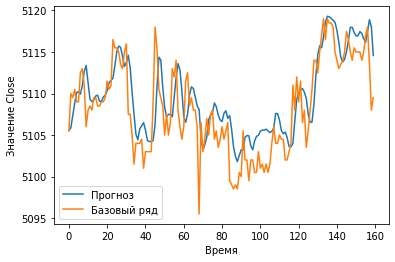

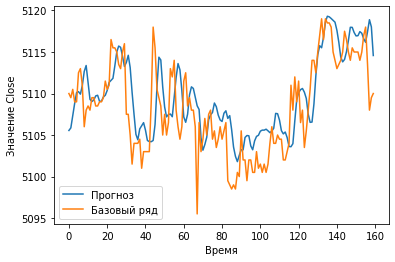

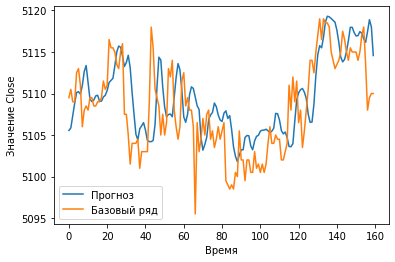

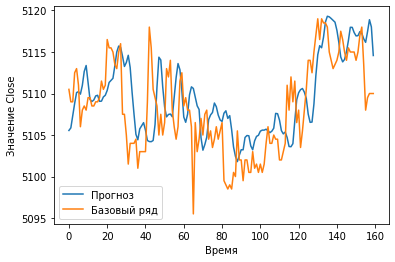

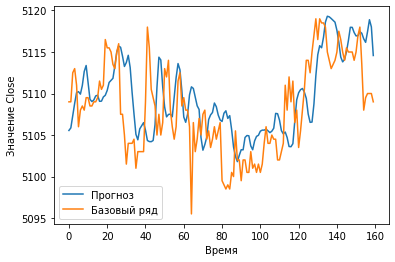

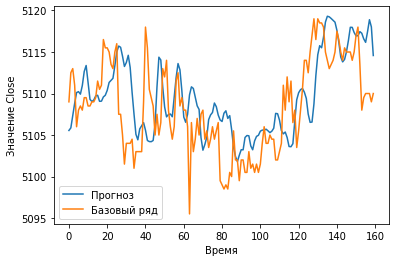

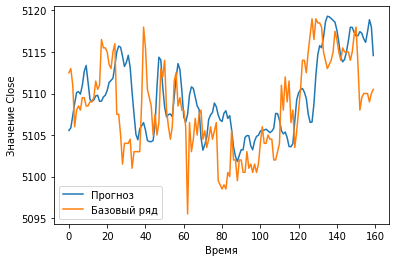

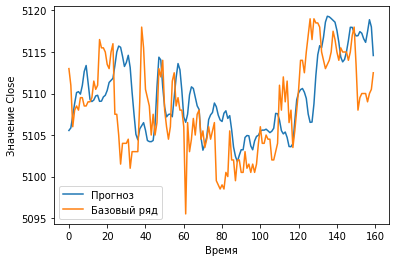

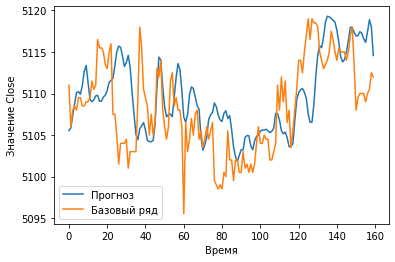

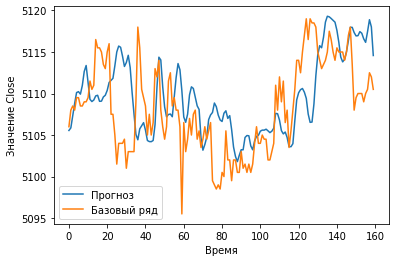

In [13]:
#Прогнозируем данные текущей сетью
currModel = modelC
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler)
for i in range(10):
    showPredict(0, 160, i, predVal, yValUnscaled)

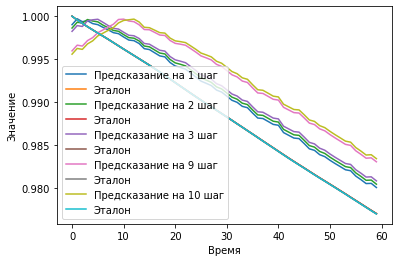

In [14]:
showCorr([0, 1, 2, 8, 9], 60, predVal, yValUnscaled)